# Classic Time Series Decomposition

Time Series Decompositions are usually the additive decomposition and the multiplicative decomposition.

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

1. Calculated the trend-cycle coponent $\hat{T}_t$ by the m-Moving Average Method. (If m is even, we can use 2xm-MA methods to make the weights more sysmetric).

2. Calculate the detrend Series: $y_t-\hat{T}_t$ or $y_t/\hat{T}_t$

3. Calculate the Seasonal Components $\hat{S}_t$

4. The error/Remainder $\hat{E}_t=y_t-\hat{T}_t-\hat{S}_t$ or $\hat{E}_t=y_t/(\hat{T}_t\times\hat{S}_t)$

In [0]:
!pip install quandl

In [0]:
## Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import Quandl package for the Finance data
import quandl

In [3]:
# Load Tesla Stock Price sample data
tesla = quandl.get('WIKI/TSLA')
print('Start date: ',tesla.index.values[0],' End date: ',tesla.index.values[-1])
tesla.head(2)

Start date:  2010-06-29T00:00:00.000000000  End date:  2018-03-27T00:00:00.000000000


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0


**At each point, resample reports the average of the previous year, while asfreq reports the value at the end of the year.**

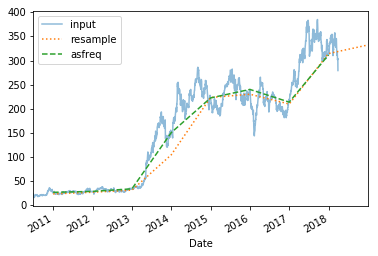

In [6]:
tesla.Close.plot(alpha=0.5, style='-')
tesla.Close.resample('BA').mean().plot(style=':')
tesla.Close.asfreq('BA').plot(style='--')
plt.legend(['input', 'resample', 'asfreq'],loc='upper left')

**The top panel is the default: non-business days are left as NA values and do not appear on the plot. The bottom panel shows the differences between two strategies for filling the gaps: forward-filling and backward-filling.**

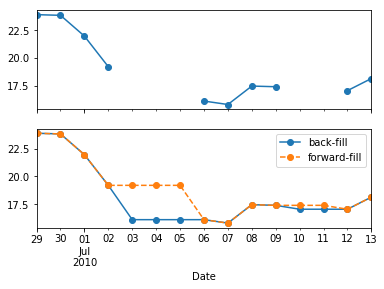

In [9]:
fig, ax = plt.subplots(2, sharex=True)
data = tesla.Close.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"])

**Let's refill the data NA values by backward-fill method**

In [14]:
data = tesla.Close
data = data.asfreq('D', method='bfill')
data.head(8)

Date
2010-06-29    23.89
2010-06-30    23.83
2010-07-01    21.96
2010-07-02    19.20
2010-07-03    16.11
2010-07-04    16.11
2010-07-05    16.11
2010-07-06    16.11
Freq: D, Name: Close, dtype: float64

## Trend-cycle component by Moving Average

We could perform rolling windows in pandas to claculate the basic moving average. Let's choos m = 30.

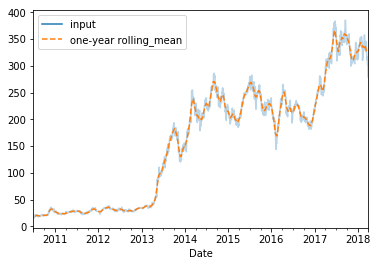

In [22]:
rolling = data.rolling(30, center=True)
data_roll = pd.DataFrame({'input': data,'30 Days Moving Average': rolling.mean()})
ax = data_roll.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

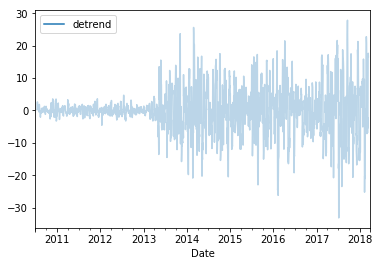

In [23]:
## Detrend data
data_detrend = pd.DataFrame({'detrend': data-rolling.mean()})
ax = data_detrend.plot(style=['-', ':'])
ax.lines[0].set_alpha(0.3)

## Seasonal component

In the classic time series decomposition, to estimate the seasonal component for each season, simply average the detrended values for that season. For example, with monthly data, the seasonal component for March is the average of all the detrended March values in the data. These seasonal component values are then adjusted to ensure that they add to zero. The seasonal component is obtained by stringing together these monthly values, and then replicating the sequence for each year of data.

From the detrend data above, we are going to select the data from 2014 to 2016 and calculate the seasonal average by month.

Text(0, 0.5, 'Weekly Close Price Average')

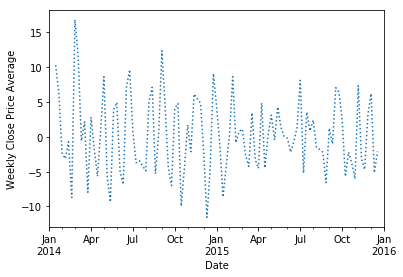

In [147]:
indexs = data.index
indexs_year = np.array([str(d).split('-')[0] for d in indexs])
data_sub1 = data.iloc[np.where(indexs_year=='2014')[0][0]:np.where(indexs_year=='2016')[0][0]]
rolling_sub1 = data_sub1.rolling(30, center=True)
data_sub1['detrend'] = data_sub1 - rolling_sub1.mean()

week_mean = data_sub1.detrend.resample('W').mean()
week_mean.plot(style=[':', '-'])
plt.ylabel('Weekly Close Price Average')

## Error/Remainder component

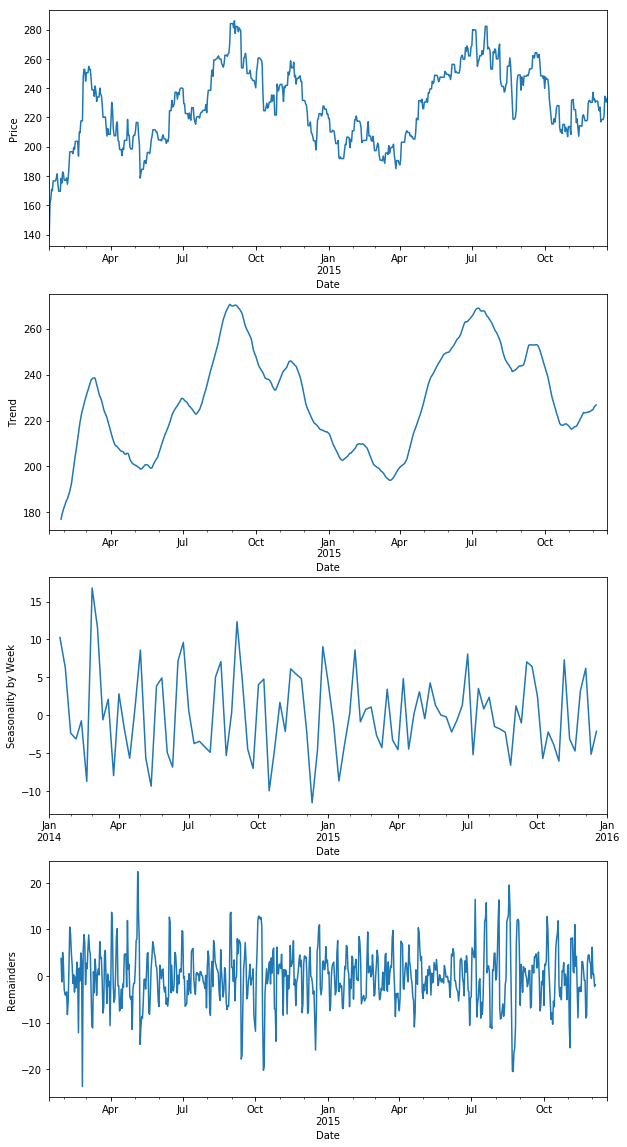

In [160]:
## Calculate the Error/Remainder first
week_mean_fill = week_mean.asfreq('D', method='bfill')
week_mean_rmna = week_mean_fill.dropna()
Input = data_sub1[np.where(np.array(data_sub1.index)==week_mean_rmna.index[0])[0][0]:\
                  np.where(np.array(data_sub1.index)==week_mean_rmna.index[-1])[0][0]]
rolling_rmna = Input.rolling(30, center=True)
detrend = Input - rolling_rmna.mean()
remainder = detrend - week_mean_rmna

## Classic Time Series Decomposition Plots
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
Input.plot(ax=ax[0])
ax[0].set_ylabel('Price')
rolling_rmna.mean().plot(ax=ax[1])
ax[1].set_ylabel('Trend')
week_mean.plot(ax=ax[2])
ax[2].set_ylabel('Seasonality by Week')
remainder.plot(ax=ax[3])
ax[3].set_ylabel('Remainders')
plt.show()

## Measuring strength of trend and seasonality

A time series decomposition can be used to measure the strength of trend and seasonality in a time series (Wang, Smith, & Hyndman, 2006). Recall that the decomposition is written as $y_t = T_t+S_t+R_t$,
 
where

$T_t$ is the smoothed trend component,  

$S_t$ is the seasonal component and  

$R_t$ is a remainder component. For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component. Therefore $\frac{Var(R_t)}{Var(T_t+R_t)}$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So we define the strength of trend as: $F_T=max(0,1-\frac{Var(R_t)}{Var(T_t+R_t)})$.
 
This will give a measure of the strength of the trend between 0 and 1. Because the variance of the remainder might occasionally be even larger than the variance of the seasonally adjusted data, we set the minimal possible value of $F_T$ equal to zero.

The strength of seasonality is defined similarly, but with respect to the detrended data rather than the seasonally adjusted data: $F_S=max(0,1-\frac{Var(R_t)}{Var(S_t+R_t)})$.
 
A series with seasonal strength  

$F_S$ close to 0 exhibits almost no seasonality, while a series with strong seasonality will have $F_S$ close to 1 because $Var(R_t)$ will be much smaller than $Var(S_t+R_t)$.

These measures can be useful, for example, when there you have a large collection of time series, and you need to find the series with the most trend or the most seasonality.

In [161]:
## Strenth of Trend
F_T = 1-np.var(remainder)/np.var(rolling_rmna.mean()+remainder)
print('F_T value is ',F_T)

## Strenth of Seasonality
F_S = 1-np.var(remainder)/np.var(week_mean_rmna+remainder)
print('F_S value is ',F_S)

F_T value is  0.933252365086051
F_S value is  0.45223946955807626


## Forecasting with decomposition

While decomposition is primarily useful for studying time series data, and exploring historical changes over time, it can also be used in forecasting.

Assuming an additive decomposition, the decomposed time series can be written as $y_t=\hat{S}_t+\hat{A}_t$,
 
where  $\hat{A}_t = \hat{T}_t+\hat{R}_t$ is the seasonally adjusted component. Or, if a multiplicative decomposition has been used, we can write $y_t=\hat{S}_t\hat{A}_t$,
 
where  $\hat{A}_t = \hat{T}_t\hat{R}_t$.

To forecast a decomposed time series, we forecast the seasonal component, $\hat{S}_t$, and the seasonally adjusted component $\hat{A}_t$, separately. It is usually assumed that the seasonal component is unchanging, or changing extremely slowly, so it is forecast by simply taking the last year of the estimated component. In other words, a seasonal naïve method is used for the seasonal component.